<a href="https://colab.research.google.com/github/FreddyR424/Deep_Learning/blob/master/Movie_Recommendation_System(GNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Recommendation System**
### **Using Graph Neural Networks**

## **Context**
- Building a recommendation system to recommend relevant movies to users based on their historical interactions, this would improve customer satisfaction and hence improve revenue.

## **Objective**
- Building a graph neural network (GNN) to suggest similar movies based on what movies a user has watched.

## **Dataset**
**'ratings' dataset:** 
- userId
- movieId
- rating
- timestamp

**'movies' dataset:**
- movieId
- title
- genres

## **Imports**

In [1]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## **Retrieving Dataset via URL**

In [2]:
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip"
)

ZipFile("movielens.zip", "r").extractall()

## **Converting Datasets into readable format**

In [3]:
# Load movies to a DataFrame
movies = pd.read_csv("ml-latest-small/movies.csv")

# Create a `movieId` string
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

# Load ratings to a DataFrame
ratings = pd.read_csv("ml-latest-small/ratings.csv") 

# Convert the `ratings` to floating point
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Create the `movie_id` string
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


In [4]:
# function to give the name of the movie from the movieId
def get_movie_title_by_id(movieId):

    return list(movies[movies.movieId == movieId].title)[0]  

# function to give the id of the movie from the name of the movie
def get_movie_id_by_title(title):

    return list(movies[movies.title == title].movieId)[0]
# look at the datasets
ratings.head()  

,userId,movieId,rating,timestamp
0,1,movie_1,4.0,964982703
1,1,movie_3,4.0,964981247
2,1,movie_6,4.0,964982224
3,1,movie_47,5.0,964983815
4,1,movie_50,5.0,964982931


In [5]:
movies.head()

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,movie_2,Jumanji (1995),Adventure|Children|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,movie_5,Father of the Bride Part II (1995),Comedy


## **Pairwise and Item Frequency**
- Calculate item_frequency for each movie and pair_frequency for every possible pair of movies.

In [6]:
min_rating = 5

item_frequency = defaultdict(int)  # Dictionary to indicate how many times each movie has been watched
pair_frequency = defaultdict(int)  # Dictionary to indicate how many times a particular pair of movies have been watched

# Filter instances where the rating is greater than or equal to min_rating
rated_movies = ratings[ratings.rating >= min_rating]

# Group instances by the user. Here, each group contains movies watched by a particular user
movies_grouped_by_users = list(rated_movies.groupby("userId"))

for group in tqdm(   
    movies_grouped_by_users,   
    position = 0,
    leave = True,
    desc = "Compute movie rating frequencies",

):  # Iterating over all the groups

    # Get a list of movies rated by the user
    current_movies = list(group[1]["movieId"])

    for i in range(len(current_movies)):
        item_frequency[current_movies[i]] += 1  # Increasing count of item frequency for a particular movie on encountering it in a group       
        for j in range(i + 1, len(current_movies)):
            x = min(current_movies[i], current_movies[j])  
            y = max(current_movies[i], current_movies[j])
            
            pair_frequency[(x, y)] += 1  # Increasing count of pair frequency for a particular pair of movies on coming across it

Compute movie rating frequencies: 100%|██████████| 573/573 [00:01<00:00, 562.55it/s]


- The first dictionary, i.e., 'item_frequency' is the item frequency where we calculate the number of times each movie has been watched, assuming every user has watched any particular movie exactly once.
- The second dictionary, i.e., 'pair_frequency' is the pair-wise frequency, where we see how many users have watched both of these movies.
- A greater value indicates higher probability of one of these movies being suggested when any new user has watched the other movie in the pair, i.e, if the pair-wise frequency of movie A and movie B is high, and a new user happens to watch movie A, they are likely to be suggested movie B.

## **Creating the Graphs**
- Model what movies are frequently watched together based on all of the user data.

In [7]:
min_weight = 10

D = math.log(sum(item_frequency.values()))

# Create the undirected graph with the movies as nodes
movies_graph = nx.Graph()

# Add weighted edges between movies
# This automatically adds the movie nodes to the graph

for pair in tqdm(
    pair_frequency, position = 0, leave = True, desc = "Creating the movie graph"
):  # Iterating over every pair of movies
    x, y = pair  # Unpacking the tuple called 'pair' to receive the two movies

    
    xy_frequency = pair_frequency[pair]  # Pair-wise frequency of two particular movies   
    x_frequency = item_frequency[x]  # Item frequency for the first movie in the pair    
    y_frequency = item_frequency[y]  # Item frequency for the second movie in the pair

    # Calculating PMI index as a measure of the pairing strength
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency

    # Only include edges with weight >= min_weight
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight = weight)  # Adding the edge to those particular nodes

Creating the movie graph: 100%|██████████| 298586/298586 [00:00<00:00, 407435.73it/s]


-  In our graph, our nodes are our movies and our edges are drawn based on the product of the PMI index and pair frequency for the two movies we are calculating the edge weight for. If this value exceeds our minimum weight (which is a hyperparameter defined by us, in this case, equal to 10) we draw an edge with the calculated weight.

In [8]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())
print("Total number of graph edges:", movies_graph.number_of_edges())

Total number of graph nodes: 1405
Total number of graph edges: 40043


## **Calculating Average Degree**
- Average degree often gives us an idea about the inter-connectivity of the nodes.

In [9]:
degrees = []

for node in movies_graph.nodes:
    degrees.append(movies_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

Average node degree: 57.0


- This average degree comes out to be 57 when we are taking the minimum weight to be 10. This gives us an idea that on average every node is connected to 57 other nodes.

## **Creating Vocabulary lookup for Embedding**

In [10]:
vocabulary = ["NA"] + list(movies_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

## **Traversing through Graph: picking the next node among all neighbors**
-  Function 'next_step()' does the simple operation of traveling to the next node given you’re currently on a node

In [11]:
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))
    weights = []

    # Adjust the weights of the edges to the neighbors with the help of p and q so that we can control or give a preference to which category of nodes we would want to visit next
    for neighbor in neighbors: # Looping through all the neighbors
        if neighbor == previous:
            # Control the probability to return to the previous node
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node
            weights.append(graph[current][neighbor]["weight"])
        else:
            # Control the probability to move forward
            weights.append(graph[current][neighbor]["weight"] / q)
    # Compute the probabilities of visiting each neighbor
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]

    # Probabilistically select a neighbor to visit
    next = np.random.choice(neighbors, size = 1, p = probabilities)[0]
    
    return next

- we have two hyperparameters, p and q, through which we can modify the probabilities a little. The value of q should lie between 1 and p. This is because the probability of visiting a node that has an edge with the current node as well as an edge with a previous node should be the greatest. The probability of a node that has an edge with the current node but not with the previous node should be lesser than the previous case. The probability of re-visiting this node should be the least.

## **Creating Walks across our Graph**
- Generate sequences of movies that are connected with each other through edges inside the graph.

In [12]:
def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())

    # Perform multiple iterations of the random walk
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)
        for node in tqdm(      
            nodes,
            position = 0,
            leave = True,
            desc = f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # Start the walk with a random node from the graph
            walk = [node]

            # Randomly walk for num_steps by calling the next_step function we created above 
            while len(walk) < num_steps:  
                current = walk[-1]  # Current node is the last element of the array 'walk'              
                previous = walk[-2] if len(walk) > 1 else None  # If the length of our array 'walk' is more than one, then the previous node is the second last element of the array 'walk'            
                next = next_step(graph, previous, current, p, q)  # Compute the next node to visit             
                walk.append(next)  # Append the next node obtained to the array 'walk'

            # Replace node ids (movieId) in the walk with token ids by looking at the vocabulary lookup
            walk = [vocabulary_lookup[token] for token in walk]

            # Add the walk to the generated sequence      
            walks.append(walk)

    return walks

## **Setting Hyperparameters for traversing through the Graph**

In [13]:
# Random walk return parameter
p = 2

# Random walk in-out parameter
q = 1.5

# Number of iterations of random walks
num_walks = 5

# Number of steps of each random walk
num_steps = 10
walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

Random walks iteration 5 of 5: 100%|██████████| 1405/1405 [00:06<00:00, 208.01it/s]

Number of walks generated: 7025


- We have set the value of p to 2, and q should lie between 1 and p. So we have chosen its value as 1.5.

## **Generating Pairs of Movies that should have closer Embeddings**
- Generate_examples( ) function, we use the skipgram function, which creates positive and negative samples.

In [14]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    
    # Iterate over all sequences (walks)
    for sequence in tqdm(       
        sequences,
        position = 0,
        leave = True,
        desc = f"Generating postive and negative examples",
    ):
        
        # Generate positive and negative skipgram pairs for a sequence or walk       
        pairs, labels = keras.preprocessing.sequence.skipgrams(           
            sequence,
            vocabulary_size = vocabulary_size,
            window_size = window_size,
            negative_samples = num_negative_samples,
        )
        for idx in range(len(pairs)):  # Iterating through all pairs received from the skipgram function
            pair = pairs[idx]  # Extracting the pair of movies
            label = labels[idx]  # Extracting the labels
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])

            if target == context:            
                continue
            if(label == 1):  # If a positive sample is generated we label them 1, otherwise we label them 0                 
                previous_negative_label = 0
                previous_negative_entry = (target, context, previous_negative_label)
                example_weights[previous_negative_entry] = 0  # Making the previous entry of the negative sample equal to zero because we have a positive sample now               
                entry = (target, context, label)               
                example_weights[entry] += 1           
            if(label == 0):  # If a negative sample is generated               
                querylabel = 1              
                queryentry = (target, context, querylabel)  # We check if a positive sample with the same pair of movies exist   
                
                if ( example_weights[queryentry]>0):              
                    continue  # We skip adding this entry to our entry if already a positive sample exists          
                else:             
                    entry = (target, context, label)             
                    example_weights[entry] +=1  # If a positive sample doesn't exist, we add the negative example

    targets, contexts, labels, weights = [], [], [], []

    for entry in example_weights:   
        weight = example_weights[entry]
    
        if(weight > 0):
            target, context, label = entry  # Tuple unpacking of the 'entry' tuple         
            targets.append(target)           
            contexts.append(context)           
            labels.append(label)            
            weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4

targets, contexts, labels, weights = generate_examples(
    sequences = walks,
    window_size = num_steps,  
    num_negative_samples = num_negative_samples,
    vocabulary_size = len(vocabulary),
)

Generating postive and negative examples: 100%|██████████| 7025/7025 [00:17<00:00, 410.33it/s]


In [15]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

Targets shape: (728614,)
Contexts shape: (728614,)
Labels shape: (728614,)
Weights shape: (728614,)


## **Generating Data in a Classification format for our Neural Network Training**

In [16]:
batch_size = 1024

def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }  # Pre-processing the targets, contexts, and labels vectors to fit our Neural Network pipeline 
    
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))  
    dataset = dataset.shuffle(buffer_size = batch_size * 2)  # Shuffling the data set to remove any chance of sequential data   
    dataset = dataset.batch(batch_size, drop_remainder = True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
 
    return dataset


dataset = create_dataset(
    targets = targets,
    contexts = contexts,
    labels = labels,
    weights = weights,  
    batch_size = batch_size,
)

## **Hyperparameters for Neural Network Training**

In [17]:
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10

## **Creating our Model**
- Building a Neural Network Architecture which would take the target and context movie as input and try to predict the output label.

In [18]:
def create_model(vocabulary_size, embedding_dim):
    inputs = {
        "target": layers.Input(name = "target", shape = (), dtype = "int32"),
        "context": layers.Input(name = "context", shape = (), dtype = "int32"),
    }
    # Initialize item embeddings   
    embed_item = layers.Embedding(
        input_dim = vocabulary_size,      
        output_dim = embedding_dim,     
        embeddings_initializer = "he_normal",     
        embeddings_regularizer = keras.regularizers.l2(1e-6),      
        name="item_embeddings",
    )
    
    # Lookup embeddings for the target
    target_embeddings = embed_item(inputs["target"])
    
    # Lookup embeddings for the context  
    context_embeddings = embed_item(inputs["context"])
    
    # Compute dot similarity between target and context embeddings 
    logits = layers.Dot(axes = 1, normalize = False, name = "dot_similarity")(
        
        [target_embeddings, context_embeddings]
    )

    # Create the model   
    model = keras.Model(inputs = inputs, outputs = logits)
    
    return model

In [19]:
model = create_model(len(vocabulary), embedding_dim)

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate),
    loss = keras.losses.BinaryCrossentropy(from_logits = True),
)  # Setting up the model's optimizers

In [20]:
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Visualizing the Model**

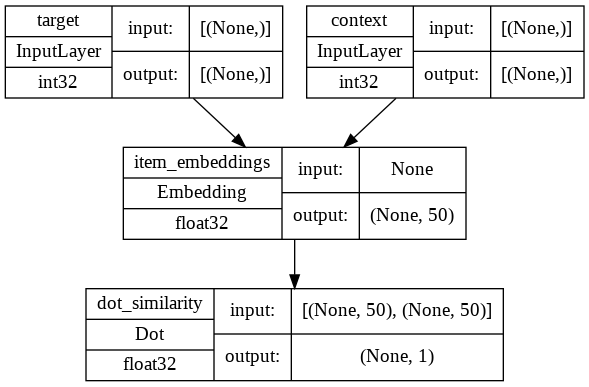

In [21]:
keras.utils.plot_model(
    model, show_shapes = True, show_dtype = True, show_layer_names = True,
)

## **Training Phase**

In [22]:
history = model.fit(dataset, epochs = num_epochs)

Epoch 1/10
711/711 [==============================] - 5s 5ms/step - loss: 2.1022
Epoch 2/10
711/711 [==============================] - 5s 7ms/step - loss: 1.7554
Epoch 3/10
711/711 [==============================] - 8s 11ms/step - loss: 1.6892
Epoch 4/10
711/711 [==============================] - 7s 9ms/step - loss: 1.6583
Epoch 5/10
711/711 [==============================] - 6s 9ms/step - loss: 1.6387
Epoch 6/10
711/711 [==============================] - 5s 7ms/step - loss: 1.6252
Epoch 7/10
711/711 [==============================] - 4s 6ms/step - loss: 1.6132
Epoch 8/10
711/711 [==============================] - 5s 7ms/step - loss: 1.6005
Epoch 9/10
711/711 [==============================] - 5s 6ms/step - loss: 1.5863
Epoch 10/10
711/711 [==============================] - 4s 5ms/step - loss: 1.5705


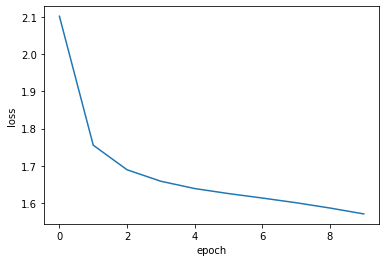

In [23]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

## **Extracting the Embedding Vector**

In [24]:
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]  # Extracting the layer weight by layer name
print("Embeddings shape:", movie_embeddings.shape)

Embeddings shape: (1406, 50)


In [25]:
query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)",
]

## **Converting Query movies to Query Embeddings**

In [26]:
query_embeddings = []

for movie_title in query_movies:
    movieId = get_movie_id_by_title(movie_title)  # Getting id from the title of the movie
    token_id = vocabulary_lookup[movieId]  # Getting index to lookup for embedding task
    movie_embedding = movie_embeddings[token_id]  # Getting embedding for query movies
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

## **Finding the top 5 similar Embeddings**

In [27]:
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),  # Normalizing the results of multiplication to get output of dot product on a scale of 0 to 1
    tf.math.l2_normalize(movie_embeddings),   
    transpose_b = True,
)

_, indices = tf.math.top_k(similarities, k = 5)

indices = indices.numpy().tolist()

## **Converting those top 5 Embeddings to Movie titles**

In [28]:
for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]

    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")

    print()

Matrix, The (1999)
------------------
- Matrix, The (1999)
- Fight Club (1999)
- Inception (2010)
- Snatch (2000)
- Star Wars: Episode VI - Return of the Jedi (1983)

Star Wars: Episode IV - A New Hope (1977)
-----------------------------------------
- Star Wars: Episode IV - A New Hope (1977)
- Star Wars: Episode VI - Return of the Jedi (1983)
- L.A. Confidential (1997)
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Shawshank Redemption, The (1994)

Lion King, The (1994)
---------------------
- Lion King, The (1994)
- Braveheart (1995)
- Beauty and the Beast (1991)
- Forrest Gump (1994)
- Die Hard: With a Vengeance (1995)

Terminator 2: Judgment Day (1991)
---------------------------------
- Terminator 2: Judgment Day (1991)
- Braveheart (1995)
- Star Wars: Episode VI - Return of the Jedi (1983)
- Jurassic Park (1993)
- Forrest Gump (1994)

Godfather, The (1972)
---------------------
- Godfather, The (1972)
- Rear Window (1954)
- Godfather: Part II, The (1974)
- Chinatown (

## **Conclusion:**

- We have converted our user data which had ratings for movies to a self-supervised task of training an embedding vector, which is ultimately helping us in suggesting top 'k' similar movies for a particular.
- We have used techniques of random walks and skipgram models to generate examples of pairs of similar nodes that help in node embedding.
- We have used a graph neural network to solve a recommendation problem.